# Teach ACT-R to Learn a production through RL

This script is implementing a simple RL framework that allows "fake" ACT-R to learn a procedural rule. The idea was based on Andrea's seminar presentation on June 2nd: Training ACT-R to learn rules without creating a production.

---

## Overview

First, I create a cognitive maze(ACT-R system) which consists of 5 main modules of ACT-R. The state space is defined as: VISUAL, GOAL, IMAGINAL, RETRIEVAL, and MOTOR. Each module represents a state *S*. To explore the cognitive maze, the agent is able to "move" from a module to another one (for example, VISUAL -> IMAGINAL). Here, I add some constains to restrict the possible path from module to module.  Only 9 paths are valid. All other paths are defined as invalid (or will be "penalized"). 

- VISUAL -> GOAL
- VISUAL -> IMAGINAL
- GOAL -> IMAGINAL
- GOAL -> RETRIEVAL
- IMAGINAL  -> GOAL
- IMAGINAL -> RETRIEVAL
- RETRIEVAL  -> IMAGINAL
- RETRIEVAL  -> GOAL
- IMAGINAL -> MOTOR

For simplification, the agent will not actually run any ACT-R command. But in the future, it would be easy to add memory rertieval process using `pyactUp` package


Reference RL tutorial: https://amunategui.github.io/reinforcement-learning/index.html



In [1]:
from agent import *
from maze import *
import seaborn as sns

### Cognitive Maze

This figure shows the cognitive maze. Imagine an agent is learning a production rule by copying a chunk from starting point (VISUAL) to end point (MOTOR). 

There are many possible paths from VISUAL to MOTOR. The agent needs to learn the optimal path of "moving" (copying chunks) from VISUAL to MOTOR. 

So, the simipliest path is: VISUAL -> IMAGINAL -> MOTOR. The cognitive process of this path is, agent *learns*  to make a response relying on working memory (imaginal buffer)

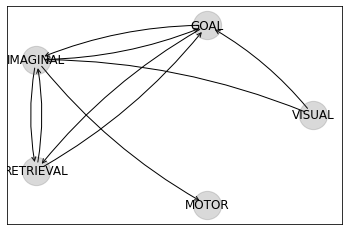

In [2]:
m = CogintiveMaze()
a = Agent()
m.draw_maze()

### Learn to use Working Memory

Next, we train this agent using q-learning to see if it could find the optimal path

In [3]:
a.q_table

matrix([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

Q-learning converges at about 250 exploration attempts.

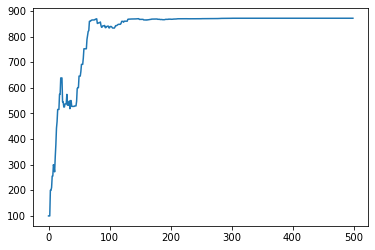

In [4]:
a.q_learning(500, v=False)

In [5]:
a.q_table.round(2)

array([[  0., 320., 400.,   0.,   0.],
       [  0.,   0., 400., 400.,   0.],
       [  0., 320.,   0., 400., 500.],
       [  0., 320., 500., 300.,   0.],
       [  0.,   0.,   0.,   0., 500.]])

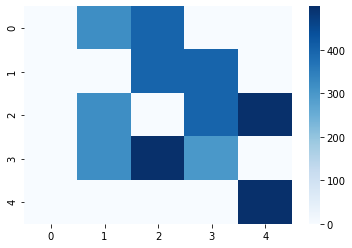

In [6]:
ax = sns.heatmap(a.q_table, cmap='Blues')

In [7]:
a.q_testing()

Learned most efficient path:
['VISUAL', 'IMAGINAL', 'MOTOR']


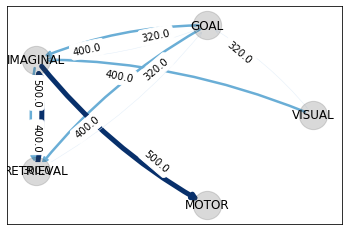

In [8]:
edge_dict = a.matrix2dict()
a.maze.draw_maze_q(edge_dict)

Great! It seems like our agent could learn to copy from VISUAL - IMAGINAL - MOTOR simple path through Q Learning in RL.


### Learn to Retrieve Memory


Since the agent would receive fixed amount of reward by reaching the goal state (MOTOR module), it is not motivated to go to RETRIEVAL module. 

Next, we might want to see, if the agent could *learn* to go a longer pathway(VISUAL - IMAGINAL - RETRIEVAL - IMAGINAL - MOTOR), if the reward is no longer fixed. And most importantly, if the agent is able to learn how to increase the possibility of obtaining rewards.


In following simulation, reward table is updated based on performance. 

- respond = None -> reward = 0
- respond = "RIGHT" -> reward = 100
- respond = "LEFT" -> reward = -100

In [9]:
m = CogintiveMaze()
a = Agent()
a.update_reward = True

In [10]:
a.q_table

matrix([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

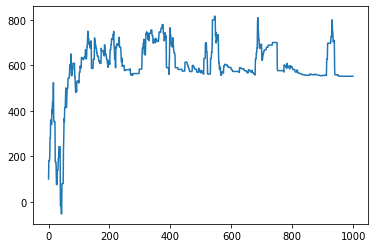

In [11]:
a.q_learning(1000, v=False)

In [12]:
a.q_table

matrix([[   0.        ,  178.05348003,  178.05348003,    0.        ,
            0.        ],
        [   0.        ,    0.        ,  178.05348003,  222.56685003,
            0.        ],
        [   0.        ,  178.05348003,    0.        ,  222.56685003,
         -100.        ],
        [   0.        ,  178.20856254,  278.20856254,  122.56685003,
            0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
         -100.        ]])

In [13]:
a.q_testing()

Learned most efficient path:
['VISUAL', 'GOAL', 'RETRIEVAL', 'IMAGINAL', 'RETRIEVAL', 'IMAGINAL', 'MOTOR']


In [14]:
a.q_table.round(2)

array([[   0.  ,  178.05,  178.05,    0.  ,    0.  ],
       [   0.  ,    0.  ,  178.05,  222.57,    0.  ],
       [   0.  ,  178.05,    0.  ,  222.57, -100.  ],
       [   0.  ,  178.21,  278.21,  122.57,    0.  ],
       [   0.  ,    0.  ,    0.  ,    0.  , -100.  ]])

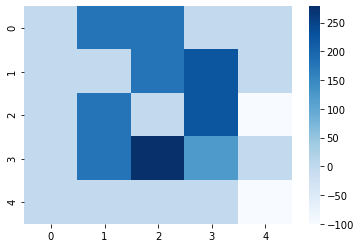

In [15]:
ax = sns.heatmap(a.q_table, cmap='Blues')

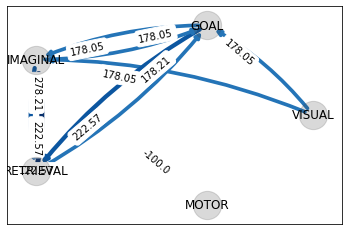

In [16]:
edge_dict = a.matrix2dict()
a.maze.draw_maze_q(edge_dict)

Unfortunatlye, the agent cannot learn to the longer pathway and it stucked in IMAGINAL - RETRIEVAL - GOAL loops

Here, I tried a stupid solution, adding constraints on self-looping. If a loop is detected, the agent has to go to make an response -> copy chunk to MOTOR module.

This method kind of solves the self-looping issue, but also has problems. The agent is no longer learning from the environment...